In [1]:
import glob
import pandas as pd
from Bio import SeqIO
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import subplots_adjust
import matplotlib.ticker as mticks
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
rcParams['mathtext.default'] = 'regular'

In [2]:
# Get the predicted localisations
def make_targetp_dict(orthogroup_targetP_files):
    targetp_df = pd.read_csv(orthogroup_targetP_files, delimiter = '\t')
    targetp_dict1 = pd.Series(targetp_df['loc'].values, index=targetp_df['gene']).to_dict()
    targetp_dict2 = {}
    for key in targetp_dict1:
        if targetp_dict1[key] == 'P':
            targetp_dict2[key] = 'PTS'
        else:
            targetp_dict2[key] = targetp_dict1[key]
    return(targetp_dict2)

In [3]:
# Fetch the relevant genes from the orthogroup
def get_species_genes(fasta_file, species_string, delimiter, delimiter_position):
    genes = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        if species_string in record.id:
            gene_list = ((record.id).split(delimiter))
            gene = delimiter.join(gene_list[:delimiter_position])
            genes.append(gene)
    return(genes)

In [4]:
def get_new_position(ax, shiftx_dist, shifty_dist):
    original_pos = ax.get_position() # get the original position 
    pos_new = [original_pos.x0 + shiftx_dist, original_pos.y0 + shifty_dist,  original_pos.width, original_pos.height] 
    return(pos_new)

In [5]:
def get_gene_model(gene, delimiter, delimiter_position):
    gene = (gene.split(delimiter))
    gene = delimiter.join(gene[:delimiter_position])
    return(gene)

In [6]:
def maize_M_BS_chang(ax, orthogroup_fasta_file):
    maize_genes = get_species_genes(orthogroup_fasta_file, 'Zm0', '_', 1)     
    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'Zm0' in key:
            orthogroup_location_dict[(key.split('_'))[0]] = targetp_dict[key]
    
    chang_df = pd.read_csv("../../DPhil/AILP1_informatics/data/RNA_seq/SRA047278_maize_chang_TPMs_concant_gene_models.csv", delim_whitespace=True)
    chang_df = chang_df.loc[chang_df['Name'].isin(maize_genes)]
    chang_df['M_mean_TPM'] = chang_df[['SRR354212_TPM', 'SRR354213_TPM']].mean(axis = 1) 
    chang_df['BS_mean_TPM'] = chang_df[['SRR354214_TPM', 'SRR354215_TPM']].mean(axis = 1)
    
    if plot_highly_expressed:
        chang_df = chang_df[(chang_df['M_mean_TPM'] + chang_df['BS_mean_TPM']) > min_mean_TPM]
    if len(chang_df) == 0:
        chang_df = chang_df.append(pd.Series(0, index=chang_df.columns), ignore_index=True)
        chang_df['Name'] = 'All genes'
        zm_colour_dict['All genes'] = (1, 1, 1, 1)
        orthogroup_location_dict['All genes'] = ''
    
    rgb_colours = []
    for i, row in chang_df.iterrows():
        if orthogroup_location_dict[row['Name']] == 'cTP':
            rgb_colours.append('#228833')
        if orthogroup_location_dict[row['Name']] == 'mTP':
            rgb_colours.append('#EE6677')
        if orthogroup_location_dict[row['Name']] == 'SP':
            rgb_colours.append('#CCBB44')
        if orthogroup_location_dict[row['Name']] == 'PTS':
            rgb_colours.append('#AA3377')
        if orthogroup_location_dict[row['Name']] == 'noTP':
            rgb_colours.append('#4477AA')
        
    chang_df['colour'] = rgb_colours
    
   
    chang_df['M_summed_mean'] = chang_df['M_mean_TPM'].groupby(chang_df['colour']).transform('sum')
    chang_df['BS_summed_mean'] = chang_df['BS_mean_TPM'].groupby(chang_df['colour']).transform('sum')
    
    cumval_M = 0
    cumval_BS = 0
    
    sorted_M = chang_df.set_index('Name').sort_values('M_summed_mean')['M_mean_TPM']
    sorted_BS = chang_df.set_index('Name').sort_values('BS_summed_mean')['BS_mean_TPM']
    colours = chang_df.set_index('Name')['colour']
    
    for name, value in sorted_M.iteritems():
        ax.bar('M', value, bottom=cumval_M, label=(orthogroup_location_dict[name] + ' ' + name), color=colours[name])
        cumval_M += value
        
    for name, value in sorted_BS.iteritems():
        ax.bar('BS', value, bottom=cumval_BS, color=colours[name])
        cumval_BS += value
    
    ax.set_ylabel('TPM')
    
    ax.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])
    
    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])

    ax.set_title('Maize', size=fig_variables['title_size'])
    
    ax.legend(loc='best', bbox_to_anchor=(1, 0.5))

In [7]:
def maize_M_BS_tausta(ax1, ax2, orthogroup_fasta_file):
    maize_genes = get_species_genes(orthogroup_fasta_file, 'Zm0', '_', 1)     
    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'Zm0' in key:
            orthogroup_location_dict[(key.split('_'))[0]] = targetp_dict[key]

    tausta_df = pd.read_csv("../../DPhil/AILP1_informatics/data/RNA_seq/SRP035577_merged_TPMs_concated_gene_models.csv", delim_whitespace=True)
    tausta_df = tausta_df.loc[tausta_df['Name'].isin(maize_genes)]

    tausta_df['M_mean_sec_4_TPM'] = tausta_df[['GSM1311350_TPM', 'GSM1311351_TPM']].mean(axis = 1)
    tausta_df['M_mean_sec_9_TPM'] = tausta_df[['GSM1311354_TPM', 'GSM1311355_TPM']].mean(axis = 1) 
    tausta_df['M_mean_sec_14_TPM'] = tausta_df[['GSM1311358_TPM', 'GSM1311359_TPM']].mean(axis = 1) 
    tausta_df['BS_mean_sec_4_TPM'] = tausta_df[['GSM1311348_TPM', 'GSM1311349_TPM']].mean(axis = 1)
    tausta_df['BS_mean_sec_9_TPM'] = tausta_df[['GSM1311352_TPM', 'GSM1311353_TPM']].mean(axis = 1) 
    tausta_df['BS_mean_sec_14_TPM'] = tausta_df[['GSM1311356_TPM', 'GSM1311357_TPM']].mean(axis = 1) 
    
    if plot_highly_expressed:
        tausta_df = tausta_df[((tausta_df['M_mean_sec_4_TPM'] + tausta_df['BS_mean_sec_4_TPM']) > min_mean_TPM) |
                             ((tausta_df['M_mean_sec_9_TPM'] + tausta_df['BS_mean_sec_9_TPM']) > min_mean_TPM) |
                             ((tausta_df['M_mean_sec_14_TPM']+ tausta_df['BS_mean_sec_14_TPM']) > min_mean_TPM)]
        if len(tausta_df) == 0:
            tausta_df = tausta_df.append(pd.Series(0, index=tausta_df.columns), ignore_index=True)
            tausta_df['Name'] = 'All genes'
            zm_colour_dict['All genes'] = (1, 1, 1, 1)
            orthogroup_location_dict['All genes'] = ''  
    
    rgb_colours = []
    for i, row in tausta_df.iterrows():
        if orthogroup_location_dict[row['Name']] == 'cTP':
            rgb_colours.append('#228833')
        if orthogroup_location_dict[row['Name']] == 'mTP':
            rgb_colours.append('#EE6677')
        if orthogroup_location_dict[row['Name']] == 'SP':
            rgb_colours.append('#CCBB44')
        if orthogroup_location_dict[row['Name']] == 'PTS':
            rgb_colours.append('#AA3377')
        if orthogroup_location_dict[row['Name']] == 'noTP':
            rgb_colours.append('#4477AA')
    tausta_df['colour'] = rgb_colours
    
    lines = ['solid','dotted','dashed','dashdot', (0,(1,10)), (0,(1,1)), (0,(5,10)), (0,(5,5)), (0,(3,10,1,10)), (0,(3,5,1,5))]
    tausta_df.sort_values(by=['colour'], inplace=True)
    tausta_df.reset_index(inplace=True)
    maize_tp_name = []
    line_styles = []
    count = 1
    for i, row in tausta_df.iterrows():
        maize_tp_name.append(orthogroup_location_dict[row['Name']] + ' ' + row['Name'])
        if i == 0:
            line_styles.append(lines[0])
            count = 1
        elif (tausta_df.iloc[i]['colour']) == (tausta_df.iloc[i-1]['colour']):
            line_styles.append(lines[count])
            count+=1
        else:
            line_styles.append(lines[0])
            count = 1
            
            
    global maize_line_dict
    maize_line_dict = dict(zip(tausta_df.Name, line_styles))

    tausta_df['maize_tp_name'] = maize_tp_name

    tausta_df = tausta_df.set_index('maize_tp_name')

    a1 = tausta_df[['M_mean_sec_4_TPM', 'M_mean_sec_9_TPM', 'M_mean_sec_14_TPM']].transpose().plot(ax=ax1, color=tausta_df['colour'], style='-', linewidth=1.5)
    a2 = tausta_df[['BS_mean_sec_4_TPM', 'BS_mean_sec_9_TPM', 'BS_mean_sec_14_TPM']].transpose().plot(ax=ax2, color=tausta_df['colour'], style='-', linewidth=1.5)
    
    for i, l in enumerate(a1.lines):
        plt.setp(l, linestyle=line_styles[i])
    for i, l in enumerate(a2.lines):
        plt.setp(l, linestyle=line_styles[i])
    
    N=3
    ax1.set_xticklabels(['-1', '+4', '+9'])
    ax2.set_xticklabels(['-1', '+4', '+9'])
    ax1.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))
    ax2.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    ax1.set_xlabel('cm from transition zone')
    ax2.set_xlabel('cm from transition zone')
    
    
    ax1.set_xlabel('cm from transition zone', fontsize=fig_variables['x_label_font_size'])
    ax2.set_xlabel('cm from transition zone', fontsize=fig_variables['x_label_font_size'])

    ax1.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])
        
    


    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])

    ax1.set_title('Maize\nmesophyll', size=fig_variables['title_size'])
    ax2.set_title('Maize\nbundle Sheath', size=fig_variables['title_size'])

    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='best', bbox_to_anchor=(1, 0.5))

In [8]:
def maize_foliar_husk_wang(ax1, ax2, orthogroup_fasta_file):
    maize_genes = get_species_genes(orthogroup_fasta_file, 'Zm0', '_', 1)     
    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'Zm0' in key:
            orthogroup_location_dict[(key.split('_'))[0]] = targetp_dict[key]

    wang_df = pd.read_csv("../../DPhil/AILP1_informatics/data/RNA_seq/SRP028231_Wang_merged_TPMs_concated_gene_models.csv", delim_whitespace=True)
    wang_df = wang_df.loc[wang_df['Name'].isin(maize_genes)]

    wang_df['F_AM_P1_P2'] = wang_df['SRR942909_TPM']
    wang_df['F_P3_P4'] = wang_df['SRR942915_TPM']
    wang_df['F_P5'] = wang_df['SRR942916_TPM']
    wang_df['F_I'] = wang_df['SRR942911_TPM']
    wang_df['F_E'] = wang_df['SRR942910_TPM']
    wang_df['H_P1_P2'] = wang_df['SRR942912_TPM']
    wang_df['H_P3_P4'] = wang_df['SRR942917_TPM']
    wang_df['H_P5'] = wang_df['SRR942918_TPM']
    wang_df['H_I'] = wang_df['SRR942913_TPM']
    wang_df['H_E'] = wang_df['SRR942914_TPM']
    
    if plot_highly_expressed:
        wang_df = wang_df[(wang_df['F_AM_P1_P2'] > min_mean_TPM) | (wang_df['F_P3_P4'] > min_mean_TPM) | (wang_df['F_P5'] > min_mean_TPM) |
                       (wang_df['F_I'] > min_mean_TPM) | (wang_df['F_E'] > min_mean_TPM) | (wang_df['H_P1_P2'] > min_mean_TPM) |
                       (wang_df['H_P3_P4'] > min_mean_TPM) | (wang_df['H_P5'] > min_mean_TPM) | (wang_df['H_I'] > min_mean_TPM) |
                       (wang_df['H_E'] > min_mean_TPM)]                
        if len(wang_df) == 0:
            wang_df = wang_df.append(pd.Series(0, index=wang_df.columns), ignore_index=True)
            wang_df['Name'] = 'All genes'
            zm_colour_dict['All genes'] = (1, 1, 1, 1)
            orthogroup_location_dict['All genes'] = ''

    rgb_colours = []
    for i, row in wang_df.iterrows():
        if orthogroup_location_dict[row['Name']] == 'cTP':
            rgb_colours.append('#228833')
        if orthogroup_location_dict[row['Name']] == 'mTP':
            rgb_colours.append('#EE6677')
        if orthogroup_location_dict[row['Name']] == 'SP':
            rgb_colours.append('#CCBB44')
        if orthogroup_location_dict[row['Name']] == 'PTS':
            rgb_colours.append('#AA3377')
        if orthogroup_location_dict[row['Name']] == 'noTP':
            rgb_colours.append('#4477AA')
    wang_df['colour'] = rgb_colours
    lines = ['solid','dotted','dashed','dashdot', (0,(1,10)), (0,(1,1)), (0,(5,10)), (0,(5,5)), (0,(3,10,1,10)), (0,(3,5,1,5))]
    wang_df.sort_values(by=['colour'], inplace=True)
    wang_df.reset_index(inplace=True)
    maize_tp_name = []
    line_styles = []
    count = 0
    
    for item in maize_line_dict.values():
        if item in lines:
            lines.remove(item)

    for i, row in wang_df.iterrows():
        maize_tp_name.append(orthogroup_location_dict[row['Name']] + ' ' + row['Name'])
        if row['Name'] in maize_line_dict:
            line_styles.append(maize_line_dict[row['Name']])
        else:
            if i == 0:
                line_styles.append(lines[0])
                count = 1
            elif (wang_df.iloc[i]['colour']) == (wang_df.iloc[i-1]['colour']):
                line_styles.append(lines[count])
                count += 1
            else:
                line_styles.append(lines[0])
                count = 1

    wang_df['maize_tp_name'] = maize_tp_name

    wang_df = wang_df.set_index('maize_tp_name')
    

    a1 = wang_df[['H_P1_P2', 'H_P3_P4', 'H_P5', 'H_I', 'H_E']].transpose().plot(ax=ax1, color=wang_df['colour'], style='-', linewidth=1.5)
    a2 = wang_df[['F_AM_P1_P2', 'F_P3_P4', 'F_P5', 'F_I', 'F_E']].transpose().plot(ax=ax2, color=wang_df['colour'], style='-', linewidth=1.5)
    
    for i, l in enumerate(a1.lines):
        plt.setp(l, linestyle=line_styles[i])
    for i, l in enumerate(a2.lines):
        plt.setp(l, linestyle=line_styles[i])
    
    N=5
    ax1.set_xticklabels(['P1-P2', 'P3-P4', 'P5', 'I', 'E'])
    ax2.set_xticklabels(['AM-P2', 'P3-P4', 'P5', 'I', 'E'])
    ax1.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))
    ax2.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    ax1.set_xlabel('Developmental stage')
    ax2.set_xlabel('Developmental stage')
    
    ax1.set_xlabel('Developmental stage', fontsize=fig_variables['x_label_font_size'])
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])
 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    ax1.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])

    ax2.set_xlabel('Developmental stage', fontsize=fig_variables['x_label_font_size'])
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])
 

    ax1.set_title('Maize\nhusk Leaf', size=fig_variables['title_size'])
    ax2.set_title('Maize\nfoliar Leaf', size=fig_variables['title_size'])
    
    ax1.legend(loc='best', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='best', bbox_to_anchor=(1, 0.5))


In [9]:
def sbicolor_M_BS_Oxford(ax, orthogroup_fasta_file):    
    sbicolor_genes = get_species_genes(orthogroup_fasta_file, 'Sobic', '.', 2)
    orthogroup_location_dict = {}
    
    for key in targetp_dict:
        if 'Sobic' in key:
            orthogroup_location_dict[get_gene_model(key, '.', 2)] = targetp_dict[key]
            
    sbicolor_df = pd.read_csv('../../DPhil/AILP1_informatics/data/RNA_seq/ERP013053_Oxford_2016_S.bicolor-M-BS_merged_TPMs_concat_gene_models.csv', delim_whitespace=True)
    sbicolor_df = sbicolor_df.loc[sbicolor_df['Name'].isin(sbicolor_genes)]
    sbicolor_df['M_mean_TPM'] = sbicolor_df[['ERR1109878_TPM', 'ERR1109879_TPM', 'ERR1109880_TPM']].mean(axis=1)
    sbicolor_df['BS_mean_TPM'] = sbicolor_df[['ERR1109875_TPM', 'ERR1109876_TPM', 'ERR1109877_TPM']].mean(axis=1)             
    
    rgb_colours = []
    for i, row in sbicolor_df.iterrows():
        if orthogroup_location_dict[row['Name']] == 'cTP':
            rgb_colours.append('#228833')
        if orthogroup_location_dict[row['Name']] == 'mTP':
            rgb_colours.append('#EE6677')
        if orthogroup_location_dict[row['Name']] == 'SP':
            rgb_colours.append('#CCBB44')
        if orthogroup_location_dict[row['Name']] == 'PTS':
            rgb_colours.append('#AA3377')
        if orthogroup_location_dict[row['Name']] == 'noTP':
            rgb_colours.append('#4477AA')
        
    sbicolor_df['colour'] = rgb_colours
    
    sbicolor_df['M_summed_mean'] = sbicolor_df['M_mean_TPM'].groupby(sbicolor_df['colour']).transform('sum')
    sbicolor_df['BS_summed_mean'] = sbicolor_df['BS_mean_TPM'].groupby(sbicolor_df['colour']).transform('sum')
    
    if plot_highly_expressed:
        sbicolor_df = sbicolor_df[((sbicolor_df['M_mean_TPM'] + sbicolor_df['BS_mean_TPM']) > min_mean_TPM)]
        if len(sbicolor_df) == 0:
            sbicolor_df = sbicolor_df.append(pd.Series(0, index=sbicolor_df.columns), ignore_index=True)
            sbicolor_df['Name'] = 'All genes'
            sb_colour_dict['All genes'] = (1, 1, 1, 1)
            orthogroup_location_dict['All genes'] = ''

    cumval_M = 0
    cumval_BS = 0
    
    sorted_M = sbicolor_df.set_index('Name').sort_values('M_summed_mean')['M_mean_TPM']
    sorted_BS = sbicolor_df.set_index('Name').sort_values('BS_summed_mean')['BS_mean_TPM']
    colours = sbicolor_df.set_index('Name')['colour']   
    
    for name, value in sorted_M.iteritems():
        ax.bar('M', value, bottom=cumval_M, label=(orthogroup_location_dict[name] + ' ' + name), color=colours[name])
        cumval_M += value
        
    for name, value in sorted_BS.iteritems():
        ax.bar('BS', value, bottom=cumval_BS, color=colours[name])
        cumval_BS += value
    
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])
    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])

    ax.set_title('$\itSorghum$ $\itbicolor$', size=fig_variables['title_size'])

In [10]:
def setaria_M_BS_john(ax, orthogroup_fasta_file):    
    sitalica_genes = get_species_genes(orthogroup_fasta_file, 'Seita', '.', 2)
    orthogroup_location_dict = {}
    
    for key in targetp_dict:
        if 'Seita' in key:
            orthogroup_location_dict[get_gene_model(key, '.', 2)] = targetp_dict[key]    
   
    john_df = pd.read_csv('../../DPhil/AILP1_informatics/data/RNA_seq/ERP004434_John_2014_merged_TPMs_concated_gene_models.csv', delim_whitespace=True)
    john_df = john_df.loc[john_df['Name'].isin(sitalica_genes)]
    john_df['M_mean_TPM'] = john_df[['ERR385861_TPM', 'ERR385862_TPM', 'ERR385863_TPM']].mean(axis=1)
    john_df['BS_mean_TPM'] = john_df[['ERR385864_TPM', 'ERR385865_TPM', 'ERR385866_TPM']].mean(axis=1)   
           
    
    rgb_colours = []
    for i, row in john_df.iterrows():
        if orthogroup_location_dict[row['Name']] == 'cTP':
            rgb_colours.append('#228833')
        if orthogroup_location_dict[row['Name']] == 'mTP':
            rgb_colours.append('#EE6677')
        if orthogroup_location_dict[row['Name']] == 'SP':
            rgb_colours.append('#CCBB44')
        if orthogroup_location_dict[row['Name']] == 'PTS':
            rgb_colours.append('#AA3377')
        if orthogroup_location_dict[row['Name']] == 'noTP':
            rgb_colours.append('#4477AA')
        
    john_df['colour'] = rgb_colours
    
    john_df['M_summed_mean'] = john_df['M_mean_TPM'].groupby(john_df['colour']).transform('sum')
    john_df['BS_summed_mean'] = john_df['BS_mean_TPM'].groupby(john_df['colour']).transform('sum')
    
    if plot_highly_expressed:
        john_df = john_df[((john_df['M_mean_TPM'] + john_df['BS_mean_TPM']) > min_mean_TPM)]
        if len(john_df) == 0:
            john_df = john_df.append(pd.Series(0, index=john_df.columns), ignore_index=True)
            john_df['Name'] = 'All genes'
            si_colour_dict['All genes'] = (1, 1, 1, 1)
            orthogroup_location_dict['All genes'] = ''
    
    cumval_M = 0
    cumval_BS = 0  
    
    sorted_M = john_df.set_index('Name').sort_values('M_summed_mean')['M_mean_TPM']
    sorted_BS = john_df.set_index('Name').sort_values('BS_summed_mean')['BS_mean_TPM']
    colours = john_df.set_index('Name')['colour']

    
    for name, value in sorted_M.iteritems():
        ax.bar('M', value, bottom=cumval_M, label=(orthogroup_location_dict[name] + ' ' + name), color=colours[name])
        cumval_M += value
        
    for name, value in sorted_BS.iteritems():
        ax.bar('BS', value, bottom=cumval_BS, color=colours[name])
        cumval_BS += value
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    #ax.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])
    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])

    ax.set_title('$\itSetaria$ $\itviridis$', size=fig_variables['title_size'])    

In [11]:
def pvirgatum_M_BS_rao(ax, orthogroup_fasta_file):   
    pvirgatum_genes = get_species_genes(orthogroup_fasta_file, 'Pavir', '.', 2)   
    orthogroup_location_dict = {}    
    
    for key in targetp_dict:
        if 'Pavir' in key:
            orthogroup_location_dict[get_gene_model(key, '.', 2)] = targetp_dict[key]
                   
    rao_df = pd.read_csv('../../DPhil/AILP1_informatics/data/RNA_seq/SAMN040029664_Pvigatum_TPMs_Rao_et_al.csv', delim_whitespace=True)
    rao_df = rao_df.loc[rao_df['Name'].isin(pvirgatum_genes)]
    rao_df['M_mean_TPM'] = rao_df[['SRR3217256_TPM', 'SRR3217257_TPM']].mean(axis=1)
    rao_df['BS_mean_TPM'] = rao_df[['SRR3217892_TPM', 'SRR3217893_TPM']].mean(axis=1) 
           
    rgb_colours = []
    for i, row in rao_df.iterrows():
        if orthogroup_location_dict[row['Name']] == 'cTP':
            rgb_colours.append('#228833')
        if orthogroup_location_dict[row['Name']] == 'mTP':
            rgb_colours.append('#EE6677')
        if orthogroup_location_dict[row['Name']] == 'SP':
            rgb_colours.append('#CCBB44')
        if orthogroup_location_dict[row['Name']] == 'PTS':
            rgb_colours.append('#AA3377')
        if orthogroup_location_dict[row['Name']] == 'noTP':
            rgb_colours.append('#4477AA')
        
    rao_df['colour'] = rgb_colours
    
    rao_df['M_summed_mean'] = rao_df['M_mean_TPM'].groupby(rao_df['colour']).transform('sum')
    rao_df['BS_summed_mean'] = rao_df['BS_mean_TPM'].groupby(rao_df['colour']).transform('sum')
    
    if plot_highly_expressed:
        rao_df = rao_df[((rao_df['M_mean_TPM'] + rao_df['BS_mean_TPM']) > min_mean_TPM)]
        if len(rao_df) == 0:
            rao_df = rao_df.append(pd.Series(0, index=rao_df.columns), ignore_index=True)
            rao_df['Name'] = 'All genes'
            pv_colour_dict['All genes'] = (1, 1, 1, 1)
            orthogroup_location_dict['All genes'] = ''
    
    cumval_M = 0
    cumval_BS = 0

    sorted_M = rao_df.set_index('Name').sort_values('M_summed_mean')['M_mean_TPM']
    sorted_BS = rao_df.set_index('Name').sort_values('BS_summed_mean')['BS_mean_TPM']
    colours = rao_df.set_index('Name')['colour']
    
    for name, value in sorted_M.iteritems():
        ax.bar('M', value, bottom=cumval_M, label=(orthogroup_location_dict[name] + ' ' + name), color=colours[name])
        cumval_M += value

    for name, value in sorted_BS.iteritems():
        ax.bar('BS', value, bottom=cumval_BS, color=colours[name])
        cumval_BS += value
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    #ax.set_ylabel('TPM', fontsize=fig_variables['y_label_font_size'])
    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])

    ax.set_title('$\itPanicum$ $\itvirgatum$', size=fig_variables['title_size'])    

In [12]:
def rice_dev_vancampen(ax, orthogroup_fasta_file):   
    rice_genes = get_species_genes(orthogroup_fasta_file, 'LOC_Os', '.', 1)  
    
    orthogroup_location_dict = {}
    
    for key in targetp_dict:
        if 'LOC_Os' in key:
            orthogroup_location_dict[get_gene_model(key, '.', 1)] = targetp_dict[key]
            
    vancampen_df = pd.read_csv('../../DPhil/AILP1_informatics/data/RNA_seq/SRP062323_Fleming_merged_TPMs_concated_gene_models.csv', delim_whitespace=True)
    vancampen_df = vancampen_df.loc[vancampen_df['Name'].isin(rice_genes)]       
                   
    vancampen_df['P3_mean_TPM'] = vancampen_df[['SRR2156305_TPM', 'SRR2156307_TPM']].mean(axis = 1)
    vancampen_df['P4_mean_TPM'] = vancampen_df[['SRR2156309_TPM', 'SRR2156312_TPM']].mean(axis = 1)
    vancampen_df['P5_mean_TPM'] = vancampen_df[['SRR2156314_TPM', 'SRR2156315_TPM']].mean(axis = 1)
    
    if plot_highly_expressed:
        vancampen_df = vancampen_df[(vancampen_df['P3_mean_TPM'] > min_mean_TPM) |
                             (vancampen_df['P4_mean_TPM'] > min_mean_TPM) |
                             (vancampen_df['P5_mean_TPM'] > min_mean_TPM) ]                
        if len(vancampen_df) == 0:
            vancampen_df = vancampen_df.append(pd.Series(0, index=vancampen_df.columns), ignore_index=True)
            vancampen_df['Name'] = 'All genes'
            os_colour_dict['All genes'] = (1, 1, 1, 1)
            orthogroup_location_dict['All genes'] = '' 

    rgb_colours = []
    for i, row in vancampen_df.iterrows():
        if orthogroup_location_dict[row['Name']] == 'cTP':
            rgb_colours.append('#228833')
        if orthogroup_location_dict[row['Name']] == 'mTP':
            rgb_colours.append('#EE6677')
        if orthogroup_location_dict[row['Name']] == 'SP':
            rgb_colours.append('#CCBB44')
        if orthogroup_location_dict[row['Name']] == 'PTS':
            rgb_colours.append('#AA3377')
        if orthogroup_location_dict[row['Name']] == 'noTP':
            rgb_colours.append('#4477AA')
        
    vancampen_df['colour'] = rgb_colours
    
    lines = ['solid','dotted','dashed','dashdot', (0,(1,10)), (0,(1,1)), (0,(5,10)), (0,(5,5)), (0,(3,10,1,10)), (0,(3,5,1,5))]
    vancampen_df.sort_values(by=['colour'], inplace=True)
    vancampen_df.reset_index(inplace=True)
    gene_tp_name = []
    line_styles = []
    count = 1
    for i, row in vancampen_df.iterrows():
        gene_tp_name.append(orthogroup_location_dict[row['Name']] + ' ' + row['Name'])
        if i == 0:
            line_styles.append(lines[0])
            count = 1
        elif (vancampen_df.iloc[i]['colour']) == (vancampen_df.iloc[i-1]['colour']):
            line_styles.append(lines[count])
            count+=1
        else:
            line_styles.append(lines[0])
            count = 1

    vancampen_df['gene_tp_name'] = gene_tp_name

    vancampen_df = vancampen_df.set_index('gene_tp_name')
    
    a1 = vancampen_df[['P3_mean_TPM', 'P4_mean_TPM', 'P5_mean_TPM']].transpose().plot(ax=ax, color=vancampen_df['colour'], style='-', linewidth=1.5)
    
    for i, l in enumerate(a1.lines):
        plt.setp(l, linestyle=line_styles[i])
    
        
    N=3
    ax.set_ylabel('TPM', fontsize=fig_variables['x_label_font_size'])
    ax.set_xticklabels(['P3', 'P4', 'P5'])
    ax.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Developmental stage', fontsize=fig_variables['x_label_font_size'])
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_title('Rice leaf development', size=fig_variables['title_size'])


In [13]:
def arabidopsis_dev_woo(ax, orthogroup_fasta_file):
    arabidopsis_genes = get_species_genes(orthogroup_fasta_file, 'AT', '.', 1)
    orthogroup_location_dict = {}
    for key in targetp_dict:
        if 'AT' in key:
            orthogroup_location_dict[(key.split('.'))[0]] = targetp_dict[key]

    woo_df = pd.read_csv('../../DPhil/AILP1_informatics/data/RNA_seq/SRP018034_Woo_merged_TPMs_concated_gene_models.csv', delim_whitespace=True)
    woo_df = woo_df.loc[woo_df['Name'].isin(arabidopsis_genes)]
    
    woo_df['4_mean_TPM'] = woo_df[['SRR2079771_TPM', 'SRR2079785_TPM']].mean(axis = 1)
    woo_df['6_mean_TPM'] = woo_df[['SRR2079772_TPM', 'SRR2079786_TPM']].mean(axis = 1)
    woo_df['8_mean_TPM'] = woo_df[['SRR2079773_TPM', 'SRR2079787_TPM']].mean(axis = 1)
    woo_df['10_mean_TPM'] = woo_df[['SRR2079774_TPM', 'SRR2079788_TPM']].mean(axis = 1)
    woo_df['12_mean_TPM'] = woo_df[['SRR2079775_TPM', 'SRR2079789_TPM']].mean(axis = 1)
    woo_df['14_mean_TPM'] = woo_df[['SRR2079776_TPM', 'SRR2079790_TPM']].mean(axis = 1)
    woo_df['16_mean_TPM'] = woo_df[['SRR2079777_TPM', 'SRR2079791_TPM']].mean(axis = 1)
    woo_df['18_mean_TPM'] = woo_df[['SRR2079778_TPM', 'SRR2079792_TPM']].mean(axis = 1)
    woo_df['20_mean_TPM'] = woo_df[['SRR2079779_TPM', 'SRR2079793_TPM']].mean(axis = 1)
    woo_df['22_mean_TPM'] = woo_df[['SRR2079780_TPM', 'SRR2079794_TPM']].mean(axis = 1)
    woo_df['24_mean_TPM'] = woo_df[['SRR2079781_TPM', 'SRR2079795_TPM']].mean(axis = 1)
    woo_df['26_mean_TPM'] = woo_df[['SRR2079781_TPM', 'SRR2079796_TPM']].mean(axis = 1)
    woo_df['28_mean_TPM'] = woo_df[['SRR2079783_TPM', 'SRR2079797_TPM']].mean(axis = 1)
    woo_df['30_mean_TPM'] = woo_df[['SRR2079784_TPM', 'SRR2079798_TPM']].mean(axis = 1)
    
    if plot_highly_expressed:
        woo_df = woo_df[(woo_df['4_mean_TPM'] > min_mean_TPM) | (woo_df['6_mean_TPM'] > min_mean_TPM) | (woo_df['8_mean_TPM'] > min_mean_TPM) |
                       (woo_df['10_mean_TPM'] > min_mean_TPM) | (woo_df['12_mean_TPM'] > min_mean_TPM) | (woo_df['14_mean_TPM'] > min_mean_TPM) |
                       (woo_df['16_mean_TPM'] > min_mean_TPM) | (woo_df['18_mean_TPM'] > min_mean_TPM) | (woo_df['20_mean_TPM'] > min_mean_TPM) |
                       (woo_df['22_mean_TPM'] > min_mean_TPM) | (woo_df['24_mean_TPM'] > min_mean_TPM) | (woo_df['26_mean_TPM'] > min_mean_TPM) |
                       (woo_df['28_mean_TPM'] > min_mean_TPM) | (woo_df['30_mean_TPM'] > min_mean_TPM)]                
        if len(woo_df) == 0:
            woo_df = woo_df.append(pd.Series(0, index=woo_df.columns), ignore_index=True)
            woo_df['Name'] = 'All genes'
            at_colour_dict['All genes'] = (1, 1, 1, 1)
            orthogroup_location_dict['All genes'] = '' 
    
    rgb_colours = []
    for i, row in woo_df.iterrows():
        if orthogroup_location_dict[row['Name']] == 'cTP':
            rgb_colours.append('#228833')
        if orthogroup_location_dict[row['Name']] == 'mTP':
            rgb_colours.append('#EE6677')
        if orthogroup_location_dict[row['Name']] == 'SP':
            rgb_colours.append('#CCBB44')
        if orthogroup_location_dict[row['Name']] == 'PTS':
            rgb_colours.append('#AA3377')
        if orthogroup_location_dict[row['Name']] == 'noTP':
            rgb_colours.append('#4477AA')
        
    woo_df['colour'] = rgb_colours
    
    lines = ['solid','dotted','dashed','dashdot', (0,(1,10)), (0,(1,1)), (0,(5,10)), (0,(5,5)), (0,(3,10,1,10)), (0,(3,5,1,5))]
    woo_df.sort_values(by=['colour'], inplace=True)
    woo_df.reset_index(inplace=True)
    
    gene_tp_name = []
    line_styles = []
    
    count = 1
    for i, row in woo_df.iterrows():
        gene_tp_name.append(orthogroup_location_dict[row['Name']] + ' ' + row['Name'])
        if i == 0:
            line_styles.append(lines[0])
            count = 1
        elif (woo_df.iloc[i]['colour']) == (woo_df.iloc[i-1]['colour']):
            line_styles.append(lines[count])
            count+=1
        else:
            line_styles.append(lines[0])
            count = 1

    woo_df['gene_tp_name'] = gene_tp_name

    woo_df = woo_df.set_index('gene_tp_name')
    
    a1 = woo_df[['4_mean_TPM', '6_mean_TPM', '8_mean_TPM', '10_mean_TPM', '12_mean_TPM', '14_mean_TPM', '16_mean_TPM', '18_mean_TPM',
            '20_mean_TPM', '22_mean_TPM', '24_mean_TPM', '26_mean_TPM', '28_mean_TPM', '30_mean_TPM'
           ]].transpose().plot(ax=ax, color=woo_df['colour'], style='-', linewidth=1.5)
    
    
    for i, l in enumerate(a1.lines):
        plt.setp(l, linestyle=line_styles[i])
    
        
    N=14
    ax.set_xticklabels(['4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30'])
    ax.set_ylabel('TPM', fontsize=fig_variables['x_label_font_size'])
    ax.get_xaxis().set_major_locator(mticks.LinearLocator(numticks=N))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Days after emergence (4th rosette leaf)', fontsize=fig_variables['x_label_font_size'])
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fig_variables['x_tick_font_size'])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_title('$\itArabidopsis$ leaf development', size=fig_variables['title_size'])

In [14]:
def plot_maize_row(index, gene_name):
    if index == 0:
        shifty = 0
    else:
        shifty = -0.05 + (-0.05*(index-1))
    
    # Chang
    ax1 = fig.add_subplot(spec[index,0])
    ax1.set_position(get_new_position(ax1, 0, shifty))
    maize_M_BS_chang(ax1, orthogroup_fasta_file)


    # Tausta
    ax2 = fig.add_subplot(spec[index, 1], sharey=ax1)
    ax3 = fig.add_subplot(spec[index, 2], sharey=ax1)
    ax2.set_position(get_new_position(ax2, 0.04, shifty))
    ax3.set_position(get_new_position(ax3, 0.04, shifty))
    maize_M_BS_tausta(ax2, ax3, orthogroup_fasta_file)


    # Wang
    ax4 = fig.add_subplot(spec[index, 3], sharey = ax1)
    ax5 = fig.add_subplot(spec[index, 4], sharey = ax1)
    ax4.set_position(get_new_position(ax4, 0.08, shifty))
    ax5.set_position(get_new_position(ax5, 0.08, shifty))
    maize_foliar_husk_wang(ax4, ax5, orthogroup_fasta_file)

    highest_len = len(ax2.lines)
    legend_axs = ax2
    
    for n, axs in enumerate([ax3, ax4, ax5]):
        if len(axs.lines) > highest_len:
            highest_len = len(axs.lines)
            legend_axs = axs
    
    ax2.legend(legend_axs.lines, [ax_line.get_label() for ax_line in legend_axs.lines])

    ax1.get_legend().remove()
    ax3.get_legend().remove()
    ax4.get_legend().remove()
    ax5.get_legend().remove()
    
    labels = [gene_name]
    axs = [ax1]
    for n, ax in enumerate(axs):  
        ax.text(-0.15, 1.15, labels[n], transform=ax.transAxes, 
            size=20, weight='normal')

In [25]:
def plot_other_C4_row(index):
    if index == 0:
        shifty = 0
    else:
        shifty = -0.05 + (-0.05*(index-1))
    
    # Emms - Sorghum
    ax1 = fig.add_subplot(spec[index,0], sharey=fig.axes[0])
    ax1.set_position(get_new_position(ax1, 0, shifty))
    sbicolor_M_BS_Oxford(ax1, orthogroup_fasta_file)

    # John - Setaria
    ax3 = fig.add_subplot(spec[index, 2], sharey=fig.axes[0])
    ax3.set_position(get_new_position(ax3, 0, shifty))
    setaria_M_BS_john(ax3, orthogroup_fasta_file)

    # Rao - Panicum
    ax5 = fig.add_subplot(spec[index, 4], sharey=fig.axes[0])
    ax5.set_position(get_new_position(ax5, 0, shifty))
    pvirgatum_M_BS_rao(ax5, orthogroup_fasta_file)

In [26]:
def plot_C3_row(index):
    if index == 0:
        shifty = 0
    else:
        shifty = -0.05 + (-0.05*(index-1))
    
    # Van Campen - Rice
    ax1 = fig.add_subplot(spec[index,0], sharey=fig.axes[0])
    ax1.set_position(get_new_position(ax1, 0, shifty))
    rice_dev_vancampen(ax1, orthogroup_fasta_file)
    
    # Woo - Arabidopsis
    ax2 = fig.add_subplot(spec[index, 2:4], sharey=fig.axes[0])
    ax2.set_position(get_new_position(ax2, 0, shifty))
    arabidopsis_dev_woo(ax2, orthogroup_fasta_file)
    
    
# subplots_adjust(left=fig_variables['left'], bottom=fig_variables['bottom'], right=fig_variables['right'], top=fig_variables['top'], wspace=fig_variables['wspace'], hspace=fig_variables['hspace'])


### Plot maize only

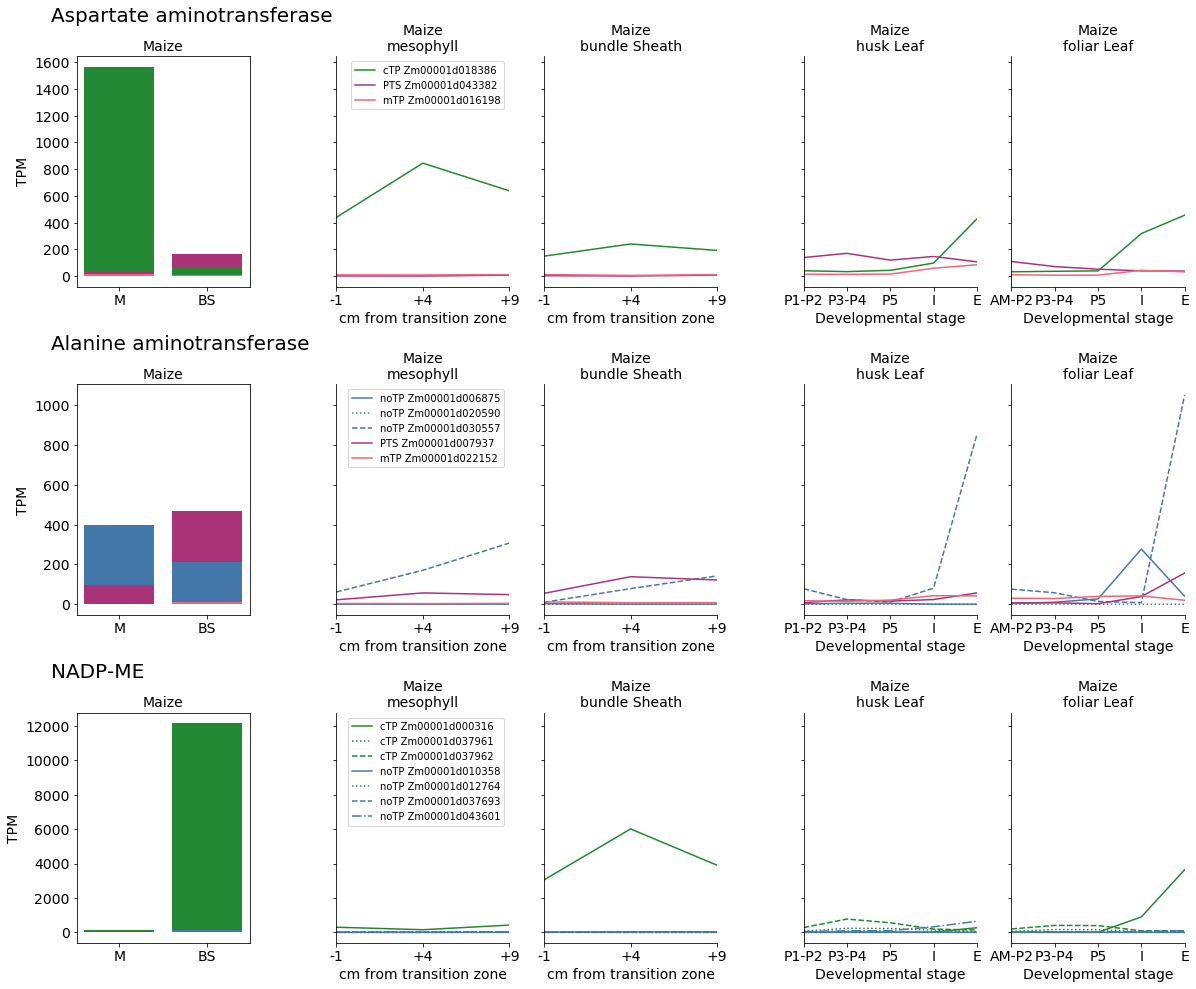

In [27]:
fig_variables = { "legend_font_size": 10, "y_label_font_size": 14, "x_label_font_size": 14, "x_tick_font_size": 14,
                  "y_tick_font_size": 12, "arabidopsis_x_tick_font_size": 12, "title_size": 14, "figsize": (18,14.4), "left": 0.125, 
                  "bottom": 0.1, "right": 0.9, "top": 0.9, "wspace": 0.2, "hspace": 0.60}

fig = plt.figure(constrained_layout=False, figsize=fig_variables['figsize'])
spec = gridspec.GridSpec(ncols=5, nrows=3, figure=fig)

global plot_highly_expressed
plot_highly_expressed = True
if plot_highly_expressed:
    global min_mean_TPM
    min_mean_TPM = 0

### aspAT ###

orthogroup_fasta_file = ('../../DPhil/AILP1_informatics/data/msa_data/Orthogroups/OG0000890.fa')
targetP_file = ('../../DPhil/AILP1_informatics/data/msa_data/targetP_results/OG0000890_targetp2_PTS.txt')
targetp_dict = make_targetp_dict(targetP_file)

plot_maize_row(0, 'Aspartate aminotransferase')

### alaAT ###

orthogroup_fasta_file = ('../../DPhil/AILP1_informatics/data/msa_data/Orthogroups/OG0000991.fa')
targetP_file = ('../../DPhil/AILP1_informatics/data/msa_data/targetP_results/OG0000991_targetp2_PTS.txt')
targetp_dict = make_targetp_dict(targetP_file)

plot_maize_row(1, 'Alanine aminotransferase')

### NADP-ME ###

orthogroup_fasta_file = ('../../DPhil/AILP1_informatics/data/msa_data/Orthogroups/OG0000779.fa')
targetP_file = ('../../DPhil/AILP1_informatics/data/msa_data/targetP_results/OG0000779_targetp2_PTS.txt')
targetp_dict = make_targetp_dict(targetP_file)

plot_maize_row(2, 'NADP-ME')


# plt.savefig('../figures/ailp1Expression.pdf', bbox_inches='tight')

### Plot wider expression for individual orthogroups

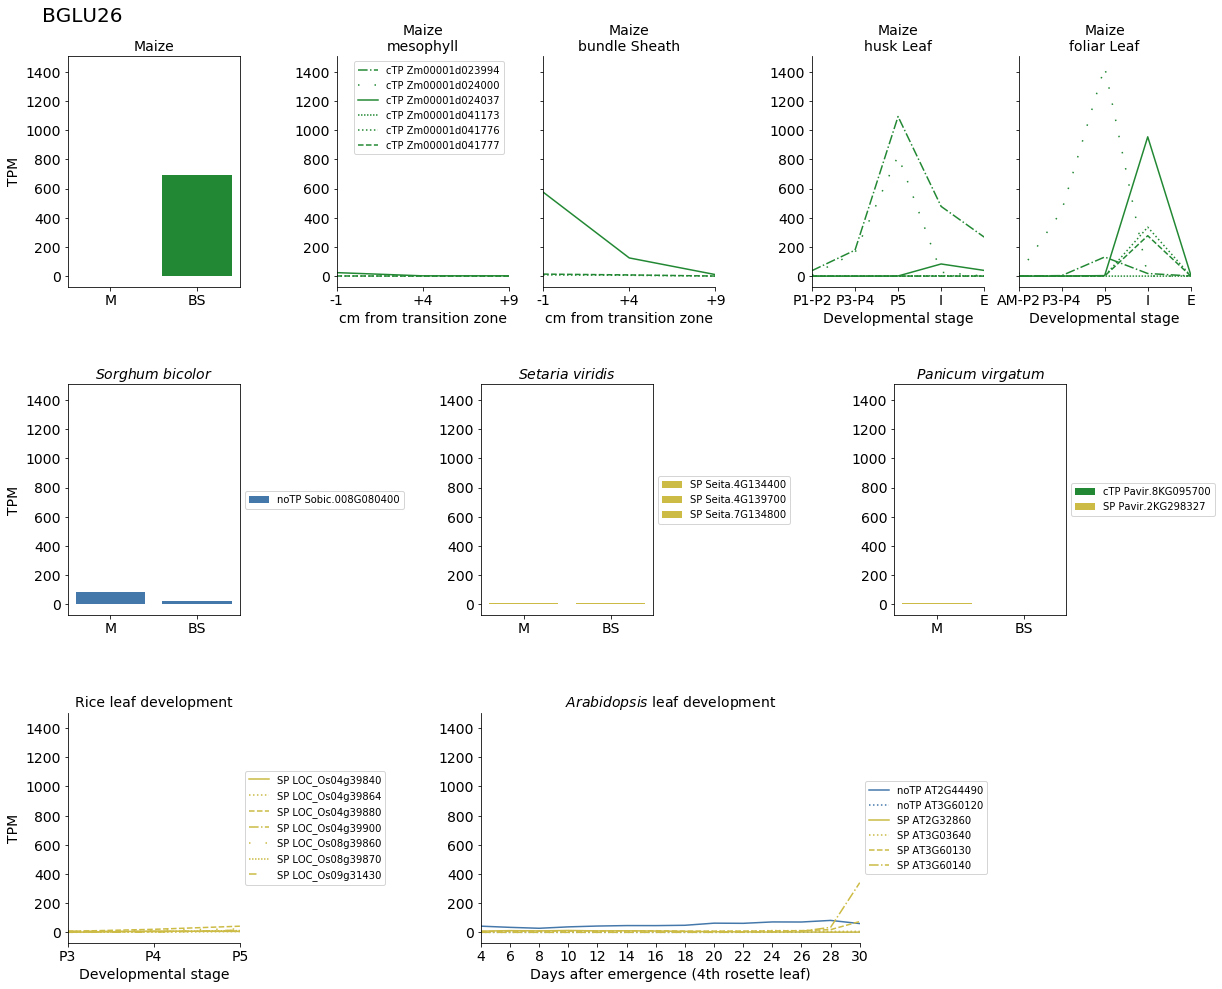

In [28]:
fig_variables = { "legend_font_size": 10, "y_label_font_size": 14, "x_label_font_size": 14, "x_tick_font_size": 14,
                  "y_tick_font_size": 12, "arabidopsis_x_tick_font_size": 12, "title_size": 14, "figsize": (21.6,14.4), "left": 0.125, 
                  "bottom": 0.1, "right": 0.9, "top": 0.9, "wspace": 0.2, "hspace": 0.60}

fig = plt.figure(constrained_layout=False, figsize=fig_variables['figsize'])
spec = gridspec.GridSpec(ncols=6, nrows=3, figure=fig)

orthogroup_fasta_file = ('../../DPhil/AILP1_informatics/data/msa_data/Orthogroups/OG0000024_black_clade_shortname.fa')
targetP_file = ('../../DPhil/AILP1_informatics/data/msa_data/targetP_results/OG0000024_black_clade_shortname_targetp2_PTS.txt')
targetp_dict = make_targetp_dict(targetP_file)

global plot_highly_expressed
plot_highly_expressed = True
if plot_highly_expressed:
    global min_mean_TPM
    min_mean_TPM = 1

plot_maize_row(0, 'BGLU26')

plot_other_C4_row(1)

plot_C3_row(2)

for n, a in enumerate(fig.axes):
    if n in [1, 3, 6, 7, 9]:
        a.tick_params(
        axis='y',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        labelleft=True)


# plt.savefig('../figures/ailp1Expression.pdf', bbox_inches='tight')